In [72]:
import pandas as pd
import numpy as np
from math import log2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [69]:
SDS = pd.read_csv("C:/Users/user/Downloads/student_exam_scores.csv")

In [4]:
SDS

,student_id,hours_studied,sleep_hours,attendance_percent,previous_scores,exam_score
0,S001,8.0,8.8,72.1,45,30.2
1,S002,1.3,8.6,60.7,55,25.0
2,S003,4.0,8.2,73.7,86,35.8
3,S004,3.5,4.8,95.1,66,34.0
4,S005,9.1,6.4,89.8,71,40.3
...,...,...,...,...,...,...
195,S196,10.5,5.4,94.0,87,42.7
196,S197,7.1,6.1,85.1,92,40.4
197,S198,1.6,6.9,63.8,76,28.2
198,S199,12.0,7.3,50.5,58,42.0


In [5]:
SDS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   student_id          200 non-null    object 
 1   hours_studied       200 non-null    float64
 2   sleep_hours         200 non-null    float64
 3   attendance_percent  200 non-null    float64
 4   previous_scores     200 non-null    int64  
 5   exam_score          200 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 9.5+ KB


In [6]:
SDS.isnull().sum()

student_id            0
hours_studied         0
sleep_hours           0
attendance_percent    0
previous_scores       0
exam_score            0
dtype: int64

In [21]:
# Create a new column to tag the student if it passes or fails
SDS["Result"] = np.where(SDS["previous_scores"] >= 60, "Pass", "Fail")

In [26]:
# Encode categorical variables like new column Result
for col in SDS.select_dtypes(include="object").columns:
    if col != "Result": 
        SDS[col] = LabelEncoder().fit_transform(SDS[col])

In [27]:
SDS["Result"] = LabelEncoder().fit_transform(SDS["Result"])

In [28]:
X = SDS.drop(columns=["previous_scores", "Result"])
y = SDS["Result"]

In [29]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

In [33]:
svm = SVC(kernel="rbf", probability=True, random_state=42)
svm.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [34]:
y_pred = svm.predict(X_test)

In [35]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7833333333333333

Confusion Matrix:
 [[15 10]
 [ 3 32]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.60      0.70        25
           1       0.76      0.91      0.83        35

    accuracy                           0.78        60
   macro avg       0.80      0.76      0.76        60
weighted avg       0.79      0.78      0.78        60



In [37]:
features = ["hours_studied", "sleep_hours", "attendance_percent"]
X_vis = SDS[features].values
X_vis_scaled = scaler.fit_transform(X_vis)

In [38]:
svm_3d = SVC(kernel="rbf", probability=True, random_state=42)
svm_3d.fit(X_vis_scaled, y)

SVC(probability=True, random_state=42)

In [39]:
x_min, x_max = X_vis_scaled[:, 0].min() - 1, X_vis_scaled[:, 0].max() + 1
y_min, y_max = X_vis_scaled[:, 1].min() - 1, X_vis_scaled[:, 1].max() + 1
z_min, z_max = X_vis_scaled[:, 2].min() - 1, X_vis_scaled[:, 2].max() + 1

In [40]:
xx, yy, zz = np.meshgrid(
    np.linspace(x_min, x_max, 20),
    np.linspace(y_min, y_max, 20),
    np.linspace(z_min, z_max, 20),
)

In [52]:
grid = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
preds = svm_3d.predict(grid)

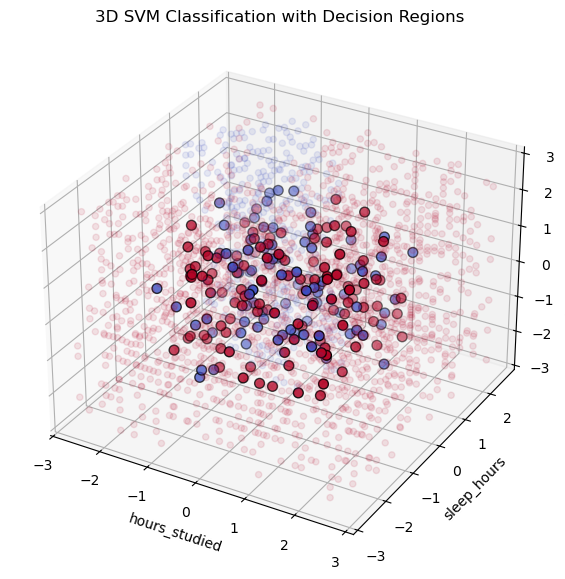

In [60]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

# Plot actual student data
ax.scatter(
    X_vis_scaled[:, 0],
    X_vis_scaled[:, 1],
    X_vis_scaled[:, 2],
    c=y,
    cmap=plt.cm.coolwarm,
    s=50,
    edgecolors="k"
)

# Plot sampled decision regions (instead of contourf, which fails in 3D)
sample_idx = np.random.choice(len(grid), size=2000, replace=False)
grid_sample = grid[sample_idx]
preds_sample = preds[sample_idx]

ax.scatter(
    grid_sample[:, 0],
    grid_sample[:, 1],
    grid_sample[:, 2],
    c=preds_sample,
    cmap=plt.cm.coolwarm,
    alpha=0.1
)

# Axis labels
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel(features[2])
ax.set_title("3D SVM Classification with Decision Regions")

plt.show()

In [63]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Random Forest Performance
Accuracy: 0.7833333333333333
              precision    recall  f1-score   support

           0       0.77      0.68      0.72        25
           1       0.79      0.86      0.82        35

    accuracy                           0.78        60
   macro avg       0.78      0.77      0.77        60
weighted avg       0.78      0.78      0.78        60

Confusion Matrix:
 [[17  8]
 [ 5 30]]


In [71]:
!pip install xgboost

  Using cached xgboost-3.0.5-py3-none-win_amd64.whl.metadata (2.1 kB)
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   - -------------------------------------- 2.6/56.8 MB 18.9 MB/s eta 0:00:03
   --- ------------------------------------ 5.5/56.8 MB 16.0 MB/s eta 0:00:04
   ------ --------------------------------- 9.2/56.8 MB 16.3 MB/s eta 0:00:03
   ------- -------------------------------- 11.0/56.8 MB 14.3 MB/s eta 0:00:04
   ---------- ----------------------------- 15.2/56.8 MB 15.7 MB/s eta 0:00:03
   ------------- -------------------------- 19.1/56.8 MB 16.5 MB/s eta 0:00:03
   --------------- ------------------------ 22.3/56.8 MB 16.0 MB/s eta 0:00:03
   ------------------ --------------------- 25.7/56.8 MB 16.1 MB/s eta 0:00:02
   -------------------- ------------------- 29.1/56.8 MB 16.3 MB/s eta 0:00:02
   ----------------------- ---------------- 32.8/56.8 MB 16.4 MB/s eta 0:00:02
   ------------------------- -------------- 36.7/56.8 MB 16.5 MB/s eta 0:

In [73]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_test)

print("\nXGBoost Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


XGBoost Performance
Accuracy: 0.7666666666666667
              precision    recall  f1-score   support

           0       0.76      0.64      0.70        25
           1       0.77      0.86      0.81        35

    accuracy                           0.77        60
   macro avg       0.77      0.75      0.75        60
weighted avg       0.77      0.77      0.76        60

Confusion Matrix:
 [[16  9]
 [ 5 30]]


C:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:15:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
